## Convert CareVue to MetaVision Tables

The files in MIMIC-III recorded with the CareVue system (abbreviated `cv`) are notoriously hard to work with as they do not contain the treatment `starttime` or `endtime`. Different rows may correspond to the same solution being administered (e.g. to set or verify the `rate` parameter or to record the total `amount` administered thus far). `charttimes` can even represent `starttimes` or `endtimes` depending on whether the `rate` or `amount` is given.

In this notebook, we convert these somewhat clumsy CareVue files to the MetaVision format (which we know and love);

#### IV Fluids
For IV fluids we can coarsely infer the `starttime` and `endtime` of treatments by considering the `charttimes` of adjacent `amount` records within a `linkorder`. A `linkorder` groups rows corresponding to the same solution/treatment, specifying changes in rate and the amounts delivered over time. According to the [MIMIC-III docs](https://mimic.mit.edu/docs/iii/tables/inputevents_cv/), `charttime` for amounts represents an `endtime` (i.e. the time at which X amount of that treatment was delivered relative to the previous `amount` record). Assuming rates remain constant between `amount` maesurements (which they most often are), we can infer the `starttime` (with the exception of the first row) as the `charttime` of the previous `amount` measurement.



In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

---
## IV Fluids

In [11]:
# Loading the data
ivfluid_cv_df = pd.read_csv('final/inputevents_cv_cohort.csv')
ivfluid_cv_df['charttime'] = pd.to_datetime(ivfluid_cv_df['charttime'])

# Sort on charttime within admission
ivfluid_cv_df = ivfluid_cv_df.sort_values(['icustay_id', 'charttime'])

# Drop rows without amounts in ml (e.g. mg of dissolved medication)
ivfluid_cv_df = ivfluid_cv_df[ivfluid_cv_df['amountuom'] == 'ml']

In [19]:
# Show random orderid
linkorderid = random.choice(ivfluid_cv_df['linkorderid'].unique())
ivfluid_cv_df[ivfluid_cv_df['linkorderid'] == linkorderid]

,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,storetime,orderid,linkorderid
4449560,15057,194991.0,259759.0,2123-01-25 13:15:00,30140,0.000000,ml,NaN,NaN,2123-01-25 13:36:00,6006156,6006156
4449561,15057,194991.0,259759.0,2123-01-25 15:00:00,30140,39.150002,ml,NaN,NaN,2123-01-25 15:11:00,934394,6006156
4449562,15057,194991.0,259759.0,2123-01-25 16:00:00,30140,20.879999,ml,NaN,NaN,2123-01-25 16:21:00,9427935,6006156
4449502,15057,194991.0,259759.0,2123-01-25 18:00:00,30140,20.880001,ml,NaN,NaN,2123-01-25 18:02:00,7361995,6006156
4449503,15057,194991.0,259759.0,2123-01-25 19:00:00,30140,0.000000,ml,NaN,NaN,2123-01-25 18:37:00,8747492,6006156
4449504,15057,194991.0,259759.0,2123-01-26 00:00:00,30140,20.879999,ml,NaN,NaN,2123-01-26 00:11:00,376001,6006156
4449505,15057,194991.0,259759.0,2123-01-26 02:00:00,30140,20.880001,ml,NaN,NaN,2123-01-26 02:42:00,4048765,6006156
4449506,15057,194991.0,259759.0,2123-01-26 04:00:00,30140,13.920000,ml,NaN,NaN,2123-01-26 04:25:00,3417646,6006156
4449507,15057,194991.0,259759.0,2123-01-26 06:00:00,30140,13.920000,ml,NaN,NaN,2123-01-26 06:42:00,9652709,6006156
4449508,15057,194991.0,259759.0,2123-01-26 08:00:00,30140,13.920000,ml,NaN,NaN,2123-01-26 08:58:00,10973455,6006156


<br>

**Limiting to the Sepsis-3 Cohort:**<br>
We can simplify our analysis by only considering treatments given to our sepsis-3 cohort (stored in `cohort.csv`) and treatments that end after the window start time (i.e. 24h prior to sepsis onset):

In [20]:
cohort_df = pd.read_csv('final/cohort.csv')
cohort_icustay_ids = {row['icustay_id'] for _, row in cohort_df.iterrows()}

# Example
list(cohort_icustay_ids)[:5] + ['...']

[294912, 229378, 229381, 294918, 294919, '...']

<br>

**Conversion CV to MV**:<br>

In [21]:
ivfluid_cv_df2 = []

# Divide up groupby on orderid to speed up the loop (search within icustay is faster and more memory efficient!)
for icustay_id, icustay_df in tqdm(ivfluid_cv_df.groupby('icustay_id', sort=False)):
    
    if icustay_id not in cohort_icustay_ids:
        continue
        
    # Get each linked order (incl. changes in rate)
    for _, linkorder_df in icustay_df.groupby('linkorderid', sort=False):
        
        # Register endtime as charttime and starttime as charttime of the previous amount record in linkorder
        # Charttimes represent endtimes for amounts, see docs: https://mimic.mit.edu/docs/iii/tables/inputevents_cv/
        linkorder_df['endtime'] = linkorder_df['charttime']
        linkorder_df['starttime'] = linkorder_df['charttime'].shift(1)
        
        # Convert linkorder_df to metavision format
        # Note: We assume a 1 hour treatment when starttime cannot be inferred as suggested in docs (and EDA): https://mimic.mit.edu/docs/iii/about/io/
        treatments = linkorder_df[['icustay_id', 'starttime', 'endtime', 'amount']].values
        treatments[0][1] = treatments[0][2] - pd.to_timedelta('1H')  # starttime = charttime - 1H
        
        ivfluid_cv_df2.append(treatments)            
            
# Save as CSV file
pd.DataFrame(np.row_stack(ivfluid_cv_df2), columns=['icustay_id', 'starttime', 'endtime', 'amount']).to_csv('final/inputevents_cv_cohort_v2.csv')

100%|████████████████████████████████████████████████████████████████████████████| 12312/12312 [04:49<00:00, 42.49it/s]


---
### Vasopressors

In [22]:
print('Vasopressors (MV)')
pd.read_csv('final/vassopressors_mv_cohort.csv', usecols=['icustay_id', 'starttime', 'endtime', 'mcgkgmin'], nrows=10)

Vasopressors (MV)


,icustay_id,starttime,endtime,mcgkgmin
0,200063,2141-03-21 11:00:00,2141-03-21 14:14:00,0.312876
1,200063,2141-03-21 14:14:00,2141-03-21 14:41:00,0.300485
2,200063,2141-03-21 14:41:00,2141-03-21 15:00:00,0.401104
3,200063,2141-03-21 15:00:00,2141-03-21 15:27:00,0.301501
4,200063,2141-03-21 15:27:00,2141-03-21 18:27:00,0.200936
5,200063,2141-03-21 16:30:00,2141-03-22 22:28:00,0.200000
6,200063,2141-03-21 18:27:00,2141-03-21 20:00:00,0.201000
7,200063,2141-03-21 20:00:00,2141-03-21 22:54:00,0.100827
8,200063,2141-03-21 22:54:00,2141-03-22 00:09:00,0.120793
9,200063,2141-03-22 00:09:00,2141-03-22 02:03:00,0.080318


In [41]:
# Loading data
vaso_cv_df = pd.read_csv('final/vassopressors_cv_cohort.csv')

vaso_cv_df['charttime'] = pd.to_datetime(vaso_cv_df['charttime'])

# Sort on charttime within admission
vaso_cv_df = vaso_cv_df.sort_values(['icustay_id', 'charttime'])
vaso_cv_df.head(10)

,icustay_id,charttime,rate,rateuom,orderid,linkorderid,vasoactive_drug,mcgkgmin
0,200003,2199-08-03 18:45:00,0.50,mcgkgmin,10556853,2934319,phenylephrine,0.2250
1,200003,2199-08-03 19:00:00,0.50,mcgkgmin,827332,2934319,phenylephrine,0.2250
2,200003,2199-08-03 19:40:00,0.50,mcgkgmin,827332,2934319,phenylephrine,0.2250
3,200003,2199-08-03 19:45:00,0.50,mcgkgmin,827332,2934319,phenylephrine,0.2250
4,200003,2199-08-03 19:50:00,0.50,mcgkgmin,827332,2934319,phenylephrine,0.2250
5,200003,2199-08-03 19:55:00,1.00,mcgkgmin,827332,2934319,phenylephrine,0.4500
6,200003,2199-08-03 20:00:00,0.75,mcgkgmin,8432715,2934319,phenylephrine,0.3375
7,200003,2199-08-03 20:15:00,0.75,mcgkgmin,8432715,2934319,phenylephrine,0.3375
8,200003,2199-08-03 20:25:00,0.50,mcgkgmin,8432715,2934319,phenylephrine,0.2250
9,200003,2199-08-03 20:30:00,0.50,mcgkgmin,8432715,2934319,phenylephrine,0.2250


<br>

**Vasopressor duration distribution:**<br>

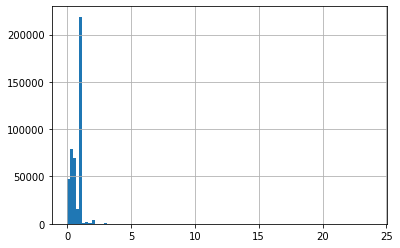

In [43]:
vaso_time_deltas = vaso_cv_df.groupby('linkorderid', sort=False)['charttime'].diff().dt.total_seconds() / 3600
vaso_time_deltas[vaso_time_deltas < 24].hist(bins=100);

In [45]:
vaso_stats = stats.mode(vaso_time_deltas)
print('Most likely duration:', vaso_stats.mode)
print('Prob. of duration    ', vaso_stats.count / len(vaso_time_deltas))

Most likely duration: [1.]
Prob. of duration     [0.48490272]


We see that vasopressors are often administered with chanegs only ocurring every hour. We will assume that for our final change it will therefore last only one hour.

<br>

**Conversion CV to MV**:<br>

In [46]:
vaso_cv_df2 = []

# Divide up groupby on orderid to speed up the loop (search within icustay is faster and more memory efficient!)
for icustay_id, icustay_df in tqdm(vaso_cv_df.groupby('icustay_id', sort=False)):
    
    if icustay_id not in cohort_icustay_ids:
        continue
        
    # Get each order (incl. changes in rate)
    for _, linkorder_df in icustay_df.groupby('linkorderid', sort=False):
        
        # Register starttime as charttime and endtime as charttime of the next rate record in linkorder
        # Charttimes represent starttimes for rates, see docs: https://mimic.mit.edu/docs/iii/tables/inputevents_cv/
        linkorder_df['starttime'] = linkorder_df['charttime']
        linkorder_df['endtime'] = linkorder_df['charttime'].shift(-1)
        
        # Convert linkorder_df to metavision format
        # Note: We assume a 1 hour treatment when endtime cannot be inferred as suggested in docs (and EDA): https://mimic.mit.edu/docs/iii/about/io/
        treatments = linkorder_df[['icustay_id', 'starttime', 'endtime', 'mcgkgmin']].values
        treatments[0][2] = treatments[0][1] + pd.to_timedelta('1H')  # endtime = charttime + 1H
        
        vaso_cv_df2.append(treatments)            
            
# Save as CSV file
pd.DataFrame(np.row_stack(vaso_cv_df2), columns=['icustay_id', 'starttime', 'endtime', 'mcgkgmin']).to_csv('final/vassopressors_cv_cohort_v2.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 3898/3898 [00:28<00:00, 138.96it/s]
